In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns

# Loading the data

For the character names and linguistic features extraction pipeline, please refer to `extract_character_attributes.ipynb`. And for the clusterization pipeline as well as the different clustering methods comparison refer to `clustering.ipynb`.

In [3]:
characters =  pd.read_csv(
    'data/character_clusters.csv', 
    index_col=0,
    converters={
        "adj": lambda x: x.strip("[]").replace("'","").split(", "), # need this to read list columns from csv
        "active": lambda x: x.strip("[]").replace("'","").split(", "),
        "patient": lambda x: x.strip("[]").replace("'","").split(", ")
        }
    )
characters.head()

,wiki_id,character,adj,active,patient,cluster
0,31186339,Peeta Mellark,[son],"[take, reveal, mean, form, present, beg, tell]",[force],29
1,31186339,Cato,[],[kill],"[encounter, wound, shoot]",55
2,31186339,Katniss,[],"[take, survive, drop, warn, run, shoot, presen...","[give, find, torment, spare, force, tell, warn]",2
3,31186339,Rue,[die],"[draw, care, draw, trap]","[hear, stab, comfort, kill]",1
4,31186339,Seneca Crane,[Gamemaker],"[change, lock]","[summon, convince]",1


In [7]:
movies = pd.read_csv(
    'data/MovieSummaries/movie.metadata.tsv', 
    sep='\t', 
    names=['wiki_id', 'freebase_id', 'title', 'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres']
)
movies.head()

,wiki_id,freebase_id,title,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
df_charac = pd.read_csv(
    'data/MovieSummaries/character.metadata.tsv', 
    sep='\t', 
    names=['wiki_id', 'freebase_id', 'release_date', 'character', 'date_of_birth', 'sex', 'height', '.','actor','age','character_map','..','...','....']
)
df_charac.head()

,wiki_id,freebase_id,release_date,character,date_of_birth,sex,height,.,actor,age,character_map,..,...,....
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,NaN
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN


In [8]:
characters_and_movies = characters.merge(movies, how='left', on='wiki_id').dropna()
characters_and_movies.head()

,wiki_id,character,adj,active,patient,cluster,freebase_id,title,release_date,revenue,runtime,languages,countries,genres
0,31186339,Peeta Mellark,[son],"[take, reveal, mean, form, present, beg, tell]",[force],29,/m/0gkz15s,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
1,31186339,Cato,[],[kill],"[encounter, wound, shoot]",55,/m/0gkz15s,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
2,31186339,Katniss,[],"[take, survive, drop, warn, run, shoot, presen...","[give, find, torment, spare, force, tell, warn]",2,/m/0gkz15s,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
3,31186339,Rue,[die],"[draw, care, draw, trap]","[hear, stab, comfort, kill]",1,/m/0gkz15s,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
4,31186339,Seneca Crane,[Gamemaker],"[change, lock]","[summon, convince]",1,/m/0gkz15s,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."


In [9]:
characters_and_movies[characters_and_movies['title'].str.contains("Batman")][['title', 'character', 'cluster']]

,title,character,cluster
6348,Superman/Batman: Apocalypse,Superman,42
6349,Superman/Batman: Apocalypse,Batman,42
6350,Superman/Batman: Apocalypse,Barda,30
6351,Superman/Batman: Apocalypse,Kara,42
6352,Superman/Batman: Apocalypse,Darkseid,23
...,...,...,...
69321,Batman Forever,Riddler,42
69322,Batman Forever,Batman,42
69323,Batman Forever,Edward Nygma,56
69324,Batman Forever,Bruce Wayne,41


# Initial analysis of the actors' success

In [10]:
map_dict_to_list = lambda x: [value for key, value in eval(x).items()]
movies['languages'] = movies['languages'].apply(map_dict_to_list)
movies['countries'] = movies['countries'].apply(map_dict_to_list)
movies['genres'] = movies['genres'].apply(map_dict_to_list)
movies.head()

,wiki_id,freebase_id,title,release_date,revenue,runtime,languages,countries,genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


Determine which character bring in the most money


In [11]:
# Merge the two datas
df_merged = df_charac.merge(movies, on=['wiki_id'], how='inner')

# Clean data of movies without box offic revenue
df_merged = df_merged.dropna(subset=['revenue'])

# Determine the actor and sum the box office revenue
actor_totalRevenue = df_merged.groupby(['actor'])['revenue'].agg(['sum', 'count']).reset_index()
actor_totalRevenue.columns = ['actor', 'bo_revenue', 'Actor Count']

# Sort the actor_revenue DataFrame in descending order
actor_revenue_sort = actor_totalRevenue.sort_values(by='bo_revenue', ascending=False)

#Extract only the top 20 best actors
actor_top20 = actor_revenue_sort.head(20)

# Merge the top 20 actors with original datas
top20_actor_data = actor_top20.merge(df_merged[['actor', 'languages','sex']], on='actor', how='left')
top20_actor_data = top20_actor_data.drop_duplicates(subset = ['actor'])
top20_actor_data.head()

,actor,bo_revenue,Actor Count,languages,sex
0,Warwick Davis,1.293016e+10,19,"[Croatian language, English Language]",M
19,Samuel L. Jackson,1.278943e+10,72,"[Russian Language, English Language]",M
91,Frank Welker,1.028744e+10,61,"[English Language, Spanish Language]",M
152,Alan Rickman,1.020871e+10,29,"[Croatian language, English Language]",M
181,Robbie Coltrane,1.009465e+10,30,"[Croatian language, English Language]",M


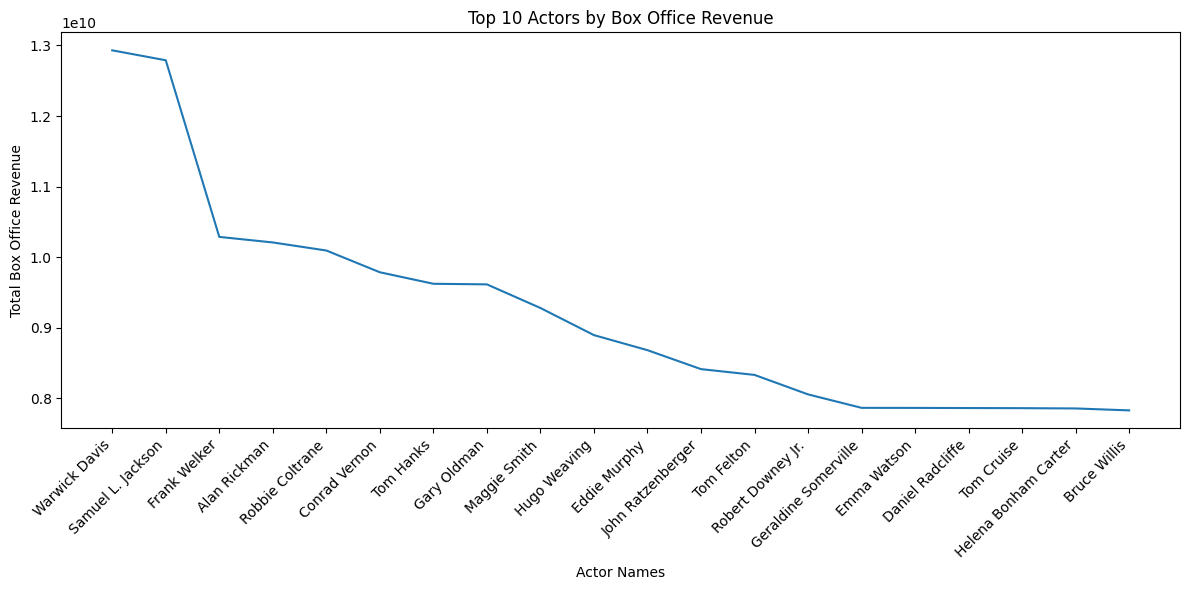

In [58]:
# Plot the data above
actor_names = top20_actor_data['actor']
revenues_total = top20_actor_data['bo_revenue']

plt.figure(figsize=(12, 6))
plt.plot(actor_names, revenues_total)
plt.xlabel('Actor Names')
plt.ylabel('Total Box Office Revenue')
plt.title('Top 10 Actors by Box Office Revenue')
plt.xticks(rotation=45, ha='right')  # Rotate the actor names for better readability

plt.tight_layout()
plt.show()



In the data above, we are ranking the actors according to the box office revenue of the movies they acted in.

Study the main lead actors obtaining the highest revenue

In [12]:
def calculater_importance(x):
    a = 0
    for w in x["adj"]:
        a += w.isalpha()
    for w in x["active"]:
        a += w.isalpha()
    for w in x["patient"]:
        a += w.isalpha()
    return a

characters['importance'] = characters.apply(calculater_importance, axis=1)

characters_with_importance = characters[['wiki_id', 'character', 'importance']]
characters_with_importance.head()

,wiki_id,character,importance
0,31186339,Peeta Mellark,9
1,31186339,Cato,4
2,31186339,Katniss,18
3,31186339,Rue,9
4,31186339,Seneca Crane,5


In [13]:
characters_with_importance['importance_share'] = characters_with_importance['importance'] / characters_with_importance.groupby('wiki_id')['importance'].transform('sum')
characters_with_importance['is_important'] = characters_with_importance['importance_share'] >= 0.2
characters_with_importance.sample(10)

C:\Users\Jiasheng\AppData\Local\Temp\ipykernel_10780\1073324314.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_with_importance['importance_share'] = characters_with_importance['importance'] / characters_with_importance.groupby('wiki_id')['importance'].transform('sum')
C:\Users\Jiasheng\AppData\Local\Temp\ipykernel_10780\1073324314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  characters_with_importance['is_important'] = characters_with_importance['importance_share'] >= 0.2


,wiki_id,character,importance,importance_share,is_important
2721,33075056,Aafreen,3,0.272727,True
34598,7839740,Matt Firenze,3,1.000000,True
71732,222534,Willa Weston,3,0.100000,False
53833,905188,John Ryder,25,0.373134,True
11719,1573381,Michael,7,0.179487,False
43568,9628464,Uncle Turpin,3,0.083333,False
36024,13860081,Von Richter,4,0.078431,False
22061,32129077,Tom Sands,11,0.478261,True
27288,2565462,Robert Mohr,5,0.135135,False
72371,26184356,Jack Cucchiaio,10,1.000000,True


In [14]:
df_charac_actor = df_merged[['wiki_id', 'character','actor','revenue']]

# Include characters and actors together in the same dataset
character_actor = df_charac_actor.merge(characters_with_importance, on=['wiki_id', 'character'], how='left')

# Merge only the main charac of movies\n",
main_character = character_actor[character_actor['is_important'] == True]

#Add up the Box office revenue and count the occurance of movie appearance
main_charac_mergedBOR = main_character.groupby(['actor'])['revenue'].agg(['sum', 'count']).reset_index()

main_charac_sort = main_charac_mergedBOR.sort_values(by='sum', ascending=False)

main_charac_top20 = main_charac_sort.head(20)
main_charac_top20.head()

,actor,sum,count
2263,Tom Cruise,5.690064e+09,19
520,Daniel Radcliffe,5.058613e+09,6
2265,Tom Hanks,4.577922e+09,18
1409,Leonardo DiCaprio,4.059193e+09,8
1595,Mel Gibson,4.048504e+09,22


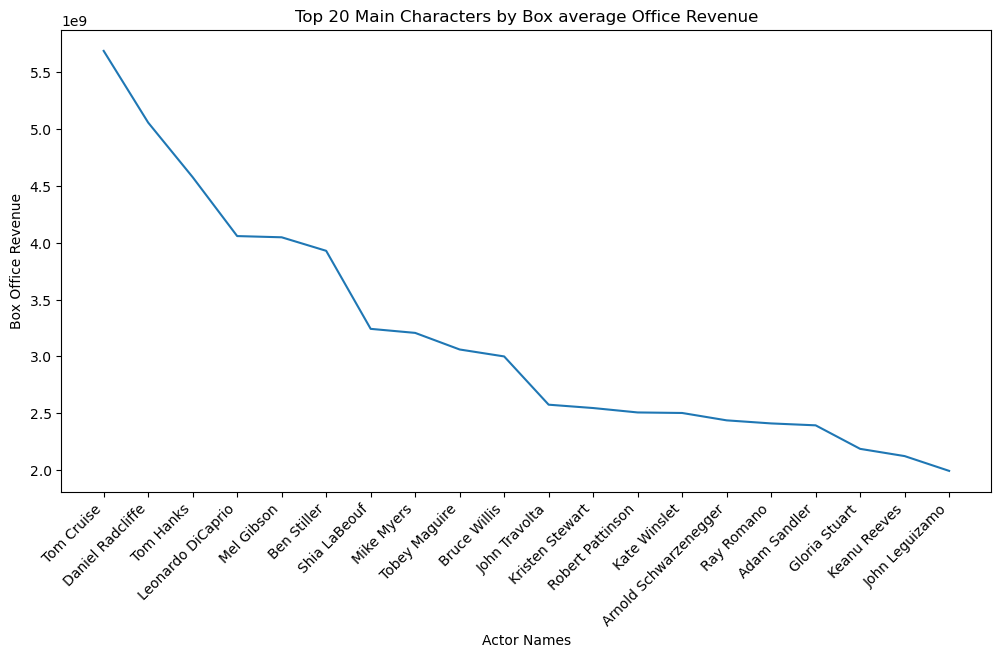

In [15]:
# Plot the charts for main actors\n",
main_charac_top20_names = main_charac_top20['actor']
main_charac_revenue = main_charac_top20['sum']

plt.figure(figsize=(12, 6))
plt.plot(main_charac_top20_names,main_charac_revenue)
plt.xlabel('Actor Names')
plt.ylabel('Box Office Revenue')
plt.title('Top 20 Main Characters by Box average Office Revenue')
plt.xticks(rotation=45, ha='right')  # Rotate the actor names for better readability

plt.show()

Male or female perform better in generating box office revenue?

In [16]:
gender_actor_data = actor_revenue_sort.merge(df_charac[['actor', 'sex']], on='actor', how='left')
gender_actor_data = gender_actor_data.drop_duplicates(subset = ['actor'])
gender_actor_data.head()

,actor,bo_revenue,Actor Count,sex
0,Warwick Davis,1.293016e+10,19,M
31,Samuel L. Jackson,1.278943e+10,72,M
137,Frank Welker,1.028744e+10,61,M
320,Alan Rickman,1.020871e+10,29,M
362,Robbie Coltrane,1.009465e+10,30,M


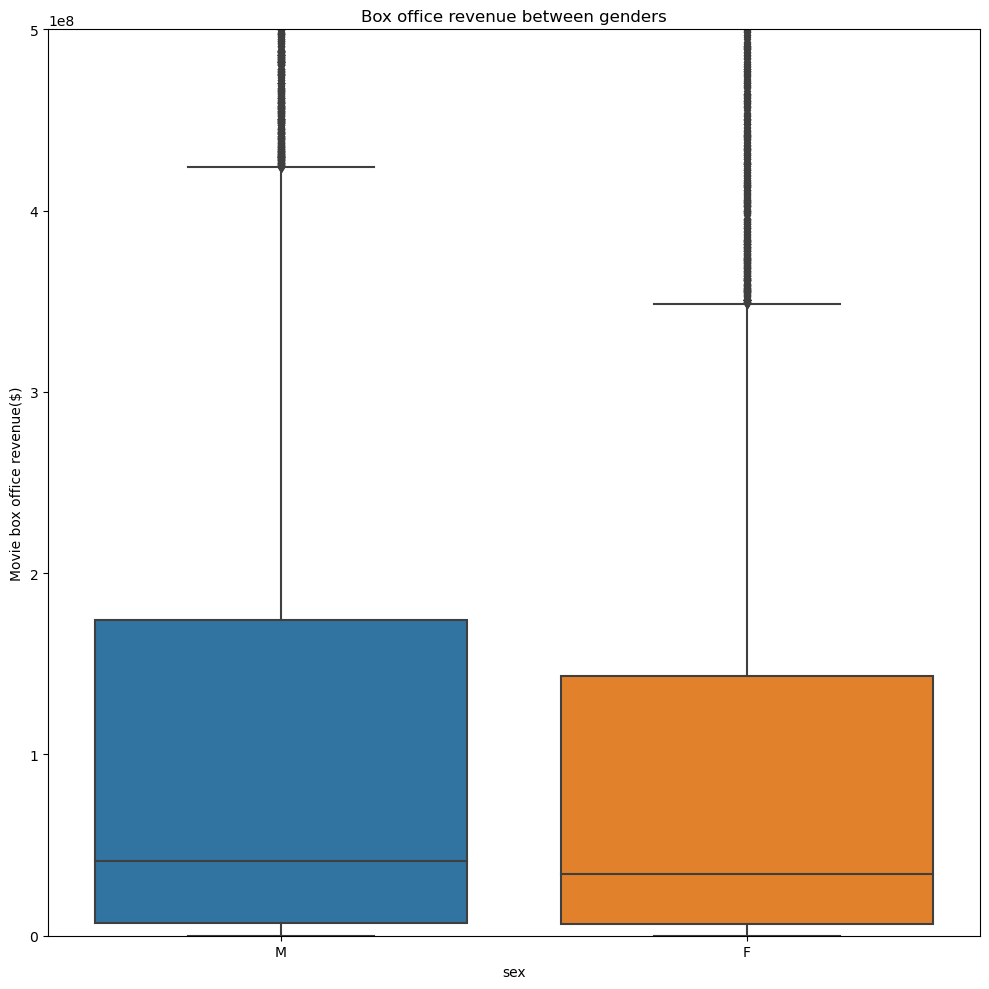

In [17]:
# Include gender into the data for box plot aalysis
gender_actor_data = actor_revenue_sort.merge(df_charac[['actor', 'sex']], on='actor', how='left')
gender_actor_data = gender_actor_data.drop_duplicates(subset = ['actor'])

# Box plot for revenue between genders
plt.figure(figsize=(10, 10))
gender_boxplot = sns.boxplot(x="sex", y="bo_revenue", data=gender_actor_data.loc[gender_actor_data['sex'].isin(['M','F'])])

# Set labels
plt.ylabel("Movie box office revenue($)")
plt.title("Box office revenue between genders")
plt.ylim(0, 500000000)
          
#Show plot
plt.tight_layout()
plt.show()

# Given the variance and the 25th percentile, 75th percentile and medan, male actors drive higher box office revenue."

Study the language used in top 50 films / Which language drive the highest revenue?

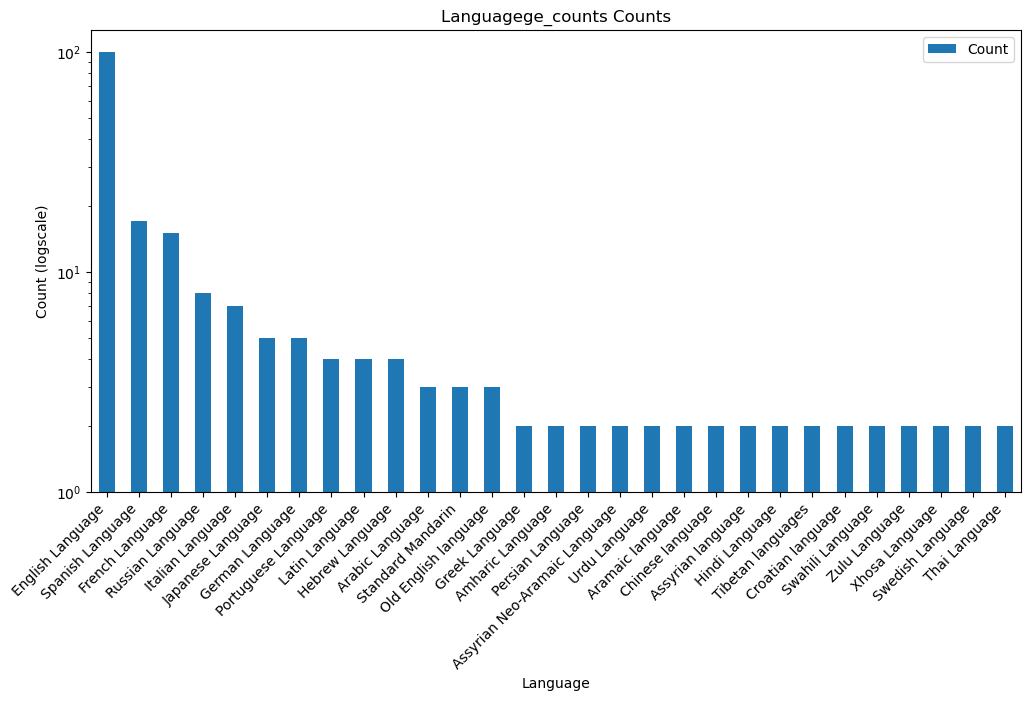

In [21]:
# Extract the top 100 movies
film_sort = df_merged[['countries','languages','revenue','wiki_id']]
film_sort = film_sort.drop_duplicates(subset = ['wiki_id'])
film_sort = film_sort.sort_values(by='revenue', ascending=False)
top100film = film_sort.head(100)

# Split the language into new data frames\
df_split_languages = top100film.explode('languages')

# Count the occurance of the languages
language_counts = df_split_languages['languages'].value_counts()
df_language_counts = pd.DataFrame({'Language': language_counts.index, 'Count': language_counts.values})

# Plot the data
df_language_counts.plot(kind='bar', x='Language', y='Count', figsize=(12, 6),log=True)
plt.title('Languagege_counts Counts')
plt.xlabel('Language')
plt.ylabel('Count (logscale)')
plt.xticks(rotation=45, ha='right')
plt.show()

Study the genre of movies that earn the highest revenue.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Drama'),
  Text(1, 0, 'Comedy'),
  Text(2, 0, 'Action'),
  Text(3, 0, 'Thriller'),
  Text(4, 0, 'Adventure'),
  Text(5, 0, 'Action/Adventure'),
  Text(6, 0, 'Fantasy'),
  Text(7, 0, 'Romance Film'),
  Text(8, 0, 'Family Film'),
  Text(9, 0, 'Science Fiction')])

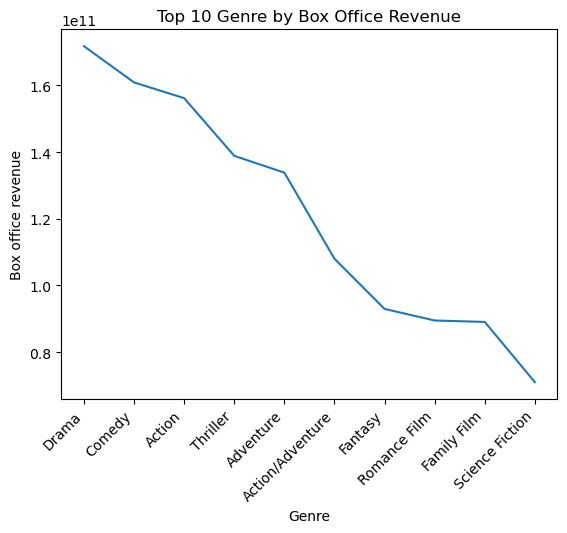

In [23]:
#Clean data to remove repeated movies
df_clean_split_genres = df_merged[['title','genres','revenue','wiki_id']]
df_clean_split_genres = df_clean_split_genres.drop_duplicates(subset = ['wiki_id'])

# Split the genre into new data frames
df_split_genre = df_clean_split_genres.explode('genres')[['title', 'revenue', 'genres']]

# Determine the actor and sum the box office revenue
genre_totalRevenue = df_split_genre.groupby('genres')['revenue'].sum().reset_index()

# Sort the BOR in ascending order
genre_totalRevenue = genre_totalRevenue.sort_values(by='revenue', ascending=False)
genre_totalRevenue_top10 = genre_totalRevenue.head(10)

genre = genre_totalRevenue_top10['genres']
genreRevenue = genre_totalRevenue_top10['revenue']

#Plot the charts
plt.plot(genre, genreRevenue)
plt.xlabel('Genre')
plt.ylabel('Box office revenue')
plt.title('Top 10 Genre by Box Office Revenue')
plt.xticks(rotation=45, ha='right')  # Rotate the actor names for better readability

<h4> Account for inflation for actors with NO prority for main actors

In [38]:
# Extract the relevent information required for inflation calculation
inf_revenue = df_merged[['wiki_id','release_date_x','character','actor','title','revenue']]
inf_revenue.head()

,wiki_id,release_date_x,character,actor,title,revenue
0,975900,2001-08-24,Akooshay,Wanda De Jesus,Ghosts of Mars,14010832.0
1,975900,2001-08-24,Lieutenant Melanie Ballard,Natasha Henstridge,Ghosts of Mars,14010832.0
2,975900,2001-08-24,Desolation Williams,Ice Cube,Ghosts of Mars,14010832.0
3,975900,2001-08-24,Sgt Jericho Butler,Jason Statham,Ghosts of Mars,14010832.0
4,975900,2001-08-24,Bashira Kincaid,Clea DuVall,Ghosts of Mars,14010832.0


In [53]:
# Convert the values to datetime format
release_year = pd.to_datetime(inf_revenue['release_date_x'], errors='coerce')

# Extract the year
release_year = release_year.dt.year
release_year = pd.to_numeric(release_year, errors='coerce').astype('Int64')

# Append year into the data
inf_revenue['year'] = release_year

# Display the result
inf_revenue.head()

C:\Users\Jiasheng\AppData\Local\Temp\ipykernel_10780\2717802652.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inf_revenue['year'] = release_year


,wiki_id,release_date_x,character,actor,title,revenue,year
0,975900,2001-08-24,Akooshay,Wanda De Jesus,Ghosts of Mars,14010832.0,2001
1,975900,2001-08-24,Lieutenant Melanie Ballard,Natasha Henstridge,Ghosts of Mars,14010832.0,2001
2,975900,2001-08-24,Desolation Williams,Ice Cube,Ghosts of Mars,14010832.0,2001
3,975900,2001-08-24,Sgt Jericho Butler,Jason Statham,Ghosts of Mars,14010832.0,2001
4,975900,2001-08-24,Bashira Kincaid,Clea DuVall,Ghosts of Mars,14010832.0,2001


In [27]:
# Determine the earliest data available
min_year = inf_revenue['year'].min()
min_year

1897

In [31]:
# Load the CPI data
cpi_data = pd.read_csv('data/cpi_data.csv', )
cpi_data.head()

,year,cpi
0,1913,9.9
1,1914,10.0
2,1915,10.1
3,1916,10.9
4,1917,12.8


In [32]:
# Merging CPI data based on the year
inf_revenue_cpi = pd.merge(inf_revenue, cpi_data, left_on='year', right_on='year', how='left')

# Calculate the adjusted revenue by dividing movie revenue by CPI
# formula: adjusted_revenue = (revenue / CPI)*100
inf_revenue_cpi['adjusted_revenue'] = (inf_revenue_cpi['revenue'] / (inf_revenue_cpi['cpi']) * 100)

# Determine the actor and sum the box office revenue
inf_actor_totalRevenue = inf_revenue_cpi.groupby(['actor'])['adjusted_revenue'].agg(['sum', 'count']).reset_index()
inf_actor_totalRevenue.columns = ['actor', 'adjusted_revenue', 'actor_count']

# Sort the actor_revenue DataFrame in descending order
cpi_revenue_sum = inf_actor_totalRevenue.sort_values(by='adjusted_revenue', ascending=False)

#Extract only the top 20 best actors
cpi_actor_top20 = cpi_revenue_sum.head(20)

# Merge the top 20 actors with original datas
cpi_actor_top20 = cpi_actor_top20.merge(df_merged[['actor', 'languages','sex']], on='actor', how='left')
cpi_actor_top20 = cpi_actor_top20.drop_duplicates(subset = ['actor'])
cpi_actor_top20.head()

,actor,adjusted_revenue,actor_count,languages,sex
0,Warwick Davis,6.976736e+09,19,"[Croatian language, English Language]",M
19,Samuel L. Jackson,6.686787e+09,65,"[Russian Language, English Language]",M
91,Frank Welker,6.177389e+09,60,"[English Language, Spanish Language]",M
152,Harrison Ford,6.071740e+09,36,"[German Language, English Language]",M
190,Tom Hanks,5.451145e+09,45,[English Language],M


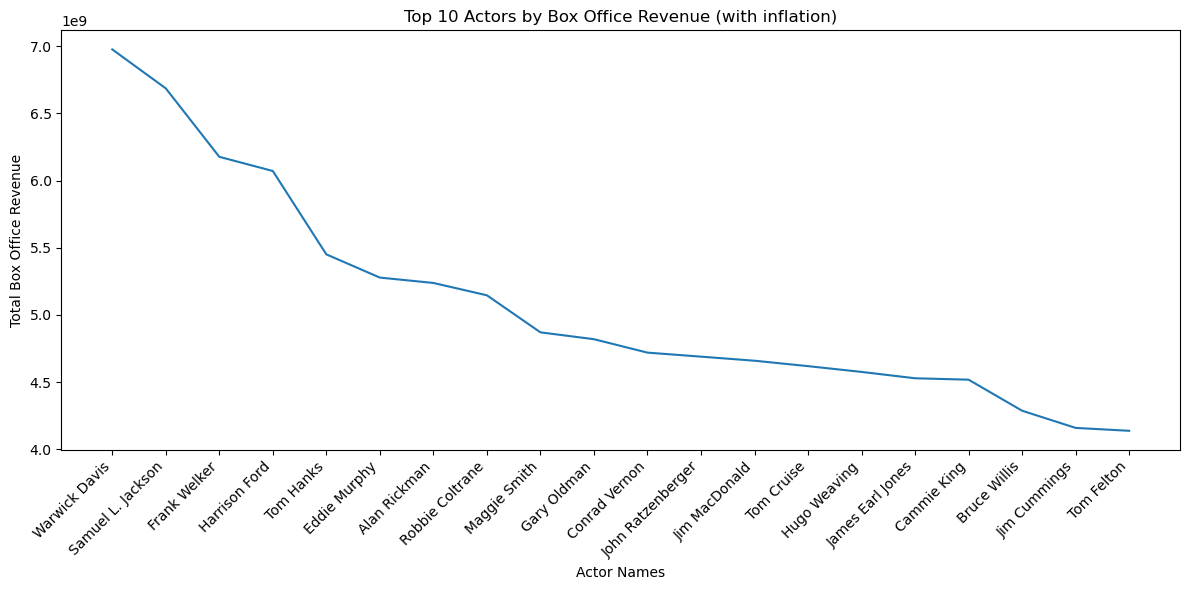

In [42]:
# Plot the data above
actor_names_cpi = cpi_actor_top20['actor']
revenues_total_cpi = cpi_actor_top20['adjusted_revenue']

plt.figure(figsize=(12, 6))
plt.plot(actor_names_cpi, revenues_total_cpi)
plt.xlabel('Actor Names')
plt.ylabel('Total Box Office Revenue')
plt.title('Top 10 Actors by Box Office Revenue (with inflation)')
plt.xticks(rotation=45, ha='right')  # Rotate the actor names for better readability

plt.tight_layout()
plt.show()

<h4> Account for inflation for actors with prority for main actors

In [56]:
main_charac_cpi = main_charac_mergedBOR.merge(inf_revenue[['actor', 'title', 'year','revenue']], on='actor', how='left')

# remove duplicated actors
main_charac_cpi = main_charac_cpi.drop_duplicates(subset = ['actor'])

#remove data without year
main_charac_cpi = main_charac_cpi.dropna(subset=['year'])

# Merging CPI data based on the year
mc_revenue_cpi = pd.merge(main_charac_cpi, cpi_data, left_on='year', right_on='year', how='left')
mc_revenue_cpi.head()

,actor,sum,count,title,year,revenue,cpi
0,50 Cent,49009245.0,2,Get Rich or Die Tryin',2005,46442528.0,195.300
1,A. J. Langer,42277365.0,1,John Carpenter's Escape from L.A.,1996,42277365.0,156.900
2,Aaron Eckhart,100418386.0,4,Suspect Zero,2004,11416075.0,188.900
3,Aaron Johnson,170312003.0,2,The Illusionist,2006,87892388.0,201.600
4,Aaron Paul,1754640.0,1,The Last House on the Left,2009,45286228.0,214.537


In [35]:
# Calculate the adjusted revenue by dividing movie revenue by CPI
# formula: adjusted_revenue = (revenue / CPI)*100
mc_revenue_cpi['adjusted_revenue'] = (mc_revenue_cpi['revenue'] / (mc_revenue_cpi['cpi']) * 100)

# Determine the actor and sum the box office revenue
mc_totalRevenue_cpi = mc_revenue_cpi.groupby(['actor'])['adjusted_revenue'].agg(['sum', 'count']).reset_index()
mc_totalRevenue_cpi.columns = ['actor', 'adjusted_revenue', 'actor_count']

# Sort the actor_revenue DataFrame in descending order
mc_totalRevenue_cpi_sort = mc_totalRevenue_cpi.sort_values(by='adjusted_revenue', ascending=False)

#Extract only the top 20 best actors
cpi_mc_actor_top20 = mc_totalRevenue_cpi_sort.head(20)

# Merge the top 20 actors with original datas
cpi_mc_actor_top20 = cpi_mc_actor_top20.merge(df_merged[['actor', 'languages','sex']], on='actor', how='left')
cpi_mc_actor_top20 = cpi_mc_actor_top20.drop_duplicates(subset = ['actor'])
cpi_mc_actor_top20.head()

,actor,adjusted_revenue,actor_count,languages,sex
0,Lucille La Verne,2.888889e+09,1,[English Language],F
1,Cammie King,2.877698e+09,1,[English Language],F
3,Bobby Stewart,1.640780e+09,1,[English Language],M
4,Donnie Dunagan,1.640780e+09,1,[English Language],M
5,John Sutherland,1.640780e+09,1,[English Language],M


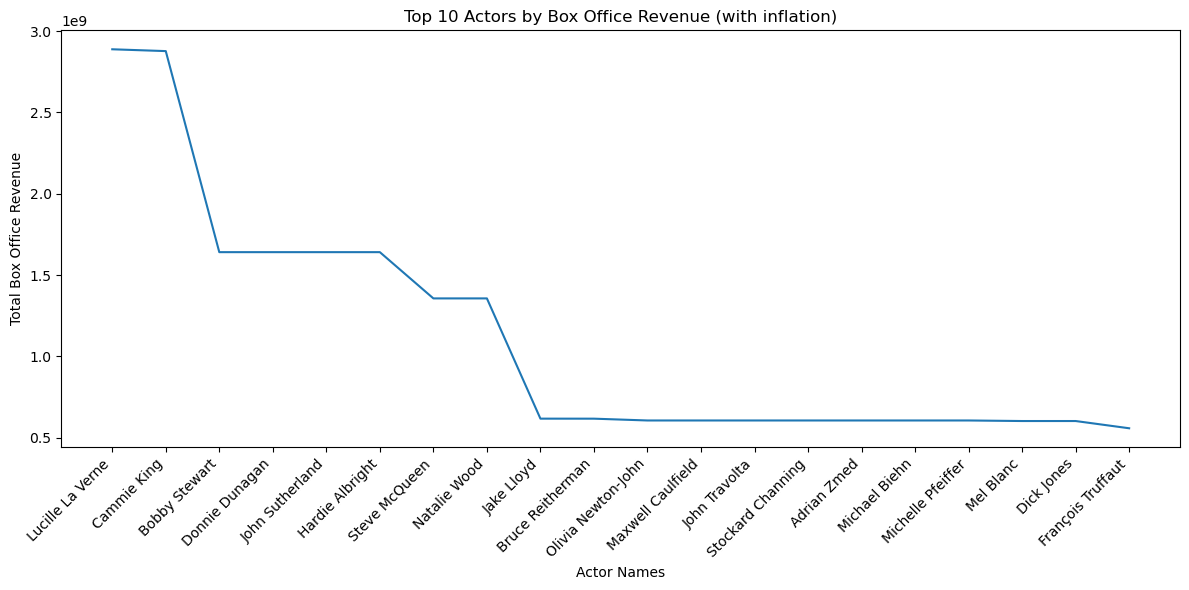

In [57]:
# Plot the data above
actor_names_cpi_main = cpi_mc_actor_top20['actor']
revenues_total_cpi_main = cpi_mc_actor_top20['adjusted_revenue']

plt.figure(figsize=(12, 6))
plt.plot(actor_names_cpi_main, revenues_total_cpi_main)
plt.xlabel('Actor Names')
plt.ylabel('Total Box Office Revenue')
plt.title('Top 20 Actors by Box Office Revenue (with inflation)')
plt.xticks(rotation=45, ha='right')  # Rotate the actor names for better readability

plt.tight_layout()
plt.show()

<h4> Giving weights to different importance to actors

In [59]:
characters_with_importance.head()

,wiki_id,character,importance,importance_share,is_important
0,31186339,Peeta Mellark,9,0.200000,True
1,31186339,Cato,4,0.088889,False
2,31186339,Katniss,18,0.400000,True
3,31186339,Rue,9,0.200000,True
4,31186339,Seneca Crane,5,0.111111,False


In [60]:
df_charac_actor.head()

,wiki_id,character,actor,revenue
0,975900,Akooshay,Wanda De Jesus,14010832.0
1,975900,Lieutenant Melanie Ballard,Natasha Henstridge,14010832.0
2,975900,Desolation Williams,Ice Cube,14010832.0
3,975900,Sgt Jericho Butler,Jason Statham,14010832.0
4,975900,Bashira Kincaid,Clea DuVall,14010832.0


In [99]:
# This data accounts for inflation, multiplying the importance foactor to the actors income
merged_char_impt = df_charac_actor.merge(characters_with_importance, on=['character'], how='inner')
merged_char_impt = merged_char_impt.drop_duplicates(subset=['actor', 'character'])
merged_char_impt.head(20)

,wiki_id_x,character,actor,revenue,wiki_id_y,importance,importance_share,is_important
0,975900,Desolation Williams,Ice Cube,14010832.0,975900,4,0.444444,True
1,975900,Uno,Duane Davis,14010832.0,24971148,9,0.375000,True
2,975900,Zimmerman,Rick Edelstein,14010832.0,9170067,3,0.176471,False
5,2525385,Zimmerman,Ivan J. Rado,6424112.0,9170067,3,0.176471,False
8,2238856,Michael,Hector Elias,8012838.0,15161056,13,0.282609,True
127,320502,Michael,Donald Sutherland,779137.0,15161056,13,0.282609,True
246,4694464,Michael,Chris Kattan,330116.0,15161056,13,0.282609,True
365,390436,Michael,Marc John Jefferies,182436254.0,15161056,13,0.282609,True
484,30885871,Michael,John C. Reilly,27520098.0,15161056,13,0.282609,True
603,73441,Michael,Robert MacNaughton,792910554.0,15161056,13,0.282609,True


In [100]:
# This data accounts for inflation, multiplying the importance foactor to the actors income
merged_char_impt = df_charac_actor.merge(characters_with_importance, on=['character'], how='inner')

# Remove actors that are duplicated
merged_char_impt = merged_char_impt.drop_duplicates(subset=['actor', 'character'])

# multiply importance_share with revenue. the value will give a measure of how impt the actors are
merged_char_impt['impt_revenue'] = (merged_char_impt['importance_share'] * merged_char_impt['revenue'] ) / merged_char_impt['revenue']

# Sum up the impt_revenue
merged_char_impt = merged_char_impt.groupby(['actor'])['impt_revenue'].agg(['sum', 'count']).reset_index()
merged_char_impt.columns = ['actor', 'impt_revenue', 'actor_count']

# Sort the data in decending order
merged_char_impt_sort = merged_char_impt.sort_values(by='impt_revenue', ascending=False)

merged_char_impt_sort_top20 = merged_char_impt_sort.head(20)
merged_char_impt_sort_top20.head()


,actor,impt_revenue,actor_count
9610,Robert De Niro,12.068949,31
2183,Clint Eastwood,11.561851,22
9714,Robin Williams,11.029792,28
8490,Nicolas Cage,10.884312,29
5599,John Travolta,10.513957,24


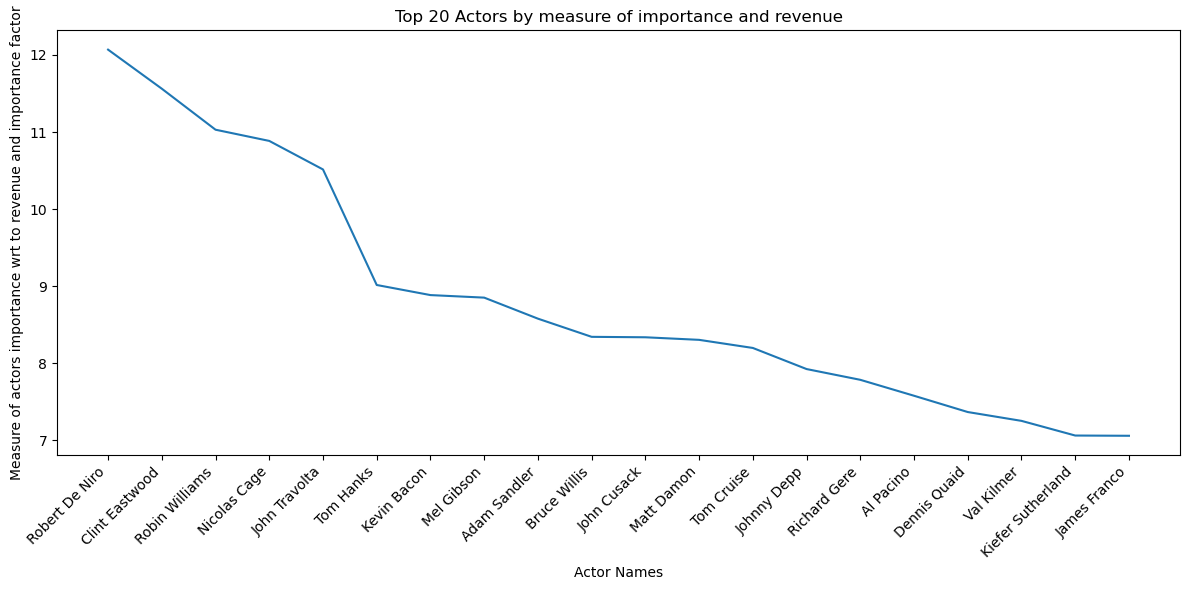

In [101]:
# Plot the data above
impt_revenue_actor_main = merged_char_impt_sort_top20['actor']
impt_revenue_revenue_main = merged_char_impt_sort_top20['impt_revenue']

plt.figure(figsize=(12, 6))
plt.plot(impt_revenue_actor_main, impt_revenue_revenue_main )
plt.xlabel('Actor Names')
plt.ylabel('Measure of actors importance wrt to revenue and importance factor')
plt.title('Top 20 Actors by measure of importance and revenue')
plt.xticks(rotation=45, ha='right')  # Rotate the actor names for better readability

plt.tight_layout()
plt.show()

In [110]:
# Taking the average of the data by dividing it with the number of movies they acted in
merged_char_impt_sort [ 'impt_revenue_avg'] = merged_char_impt_sort ['impt_revenue'] / merged_char_impt_sort ['actor_count']

# Sort the data in decending order
avg_char_impt_sort = merged_char_impt_sort.sort_values(by='impt_revenue', ascending=False)
avg_char_impt_sort = avg_char_impt_sort.head(20)



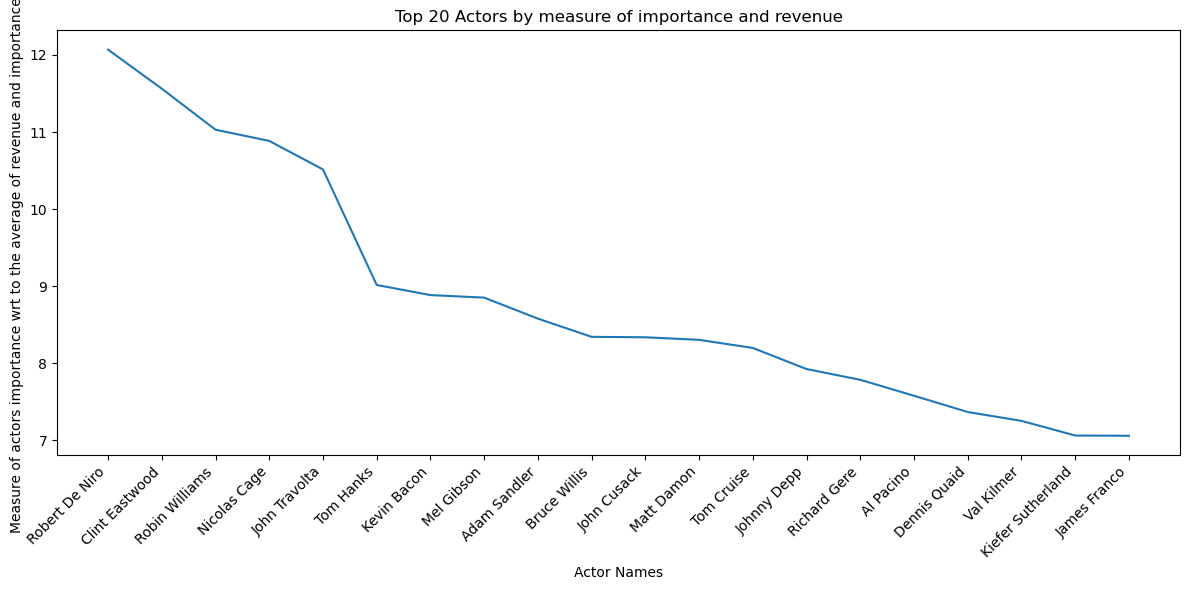

In [111]:
# Plot the data above
avg_char_impt_sort_main_actor = avg_char_impt_sort['actor']
avg_char_impt_sort_main_revenue = avg_char_impt_sort['impt_revenue']

plt.figure(figsize=(12, 6))
plt.plot(avg_char_impt_sort_main_actor, avg_char_impt_sort_main_revenue )
plt.xlabel('Actor Names')
plt.ylabel('Measure of actors importance wrt to the average of revenue and importance factor')
plt.title('Top 20 Actors by measure of importance and revenue')
plt.xticks(rotation=45, ha='right')  # Rotate the actor names for better readability

plt.tight_layout()
plt.show()

<h4> Examine the effects of rating

In [117]:
df_rating = pd.read_csv('data/movies_with_rating.csv', )
df_rating.head()

,Unnamed: 0,wiki_id,freebase_id,title,release_date,revenue,runtime,languages,countries,genres,averageRating,numVotes
0,0,10109752,/m/02q23xk,Miss Jerry,1894-10-09,NaN,NaN,"{""/m/06ppq"": ""Silent film""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",5.3,208
1,1,28703057,/m/0czdh_n,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,NaN,{},{},"{""/m/01z02hx"": ""Sports""}",5.3,485
2,2,142995,/m/0120y4,The Story of the Kelly Gang,1906-12-26,NaN,70.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0chghy"": ""Australia""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/06ppq"": ""Sil...",6.0,855
3,3,32986669,/m/04p7yxx,Robbery Under Arms,1907-11-02,NaN,NaN,"{""/m/06ppq"": ""Silent film""}","{""/m/0chghy"": ""Australia""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",4.3,25
4,4,15128675,/m/03hjcy9,Hamlet,1908,NaN,NaN,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France""}","{""/m/06ppq"": ""Silent film"", ""/m/07s9rl0"": ""Dra...",2.9,27


<h4> Plotting the actor's success based on their rating

# Genre prediction using clusters

# Revenue prediction using clusters